In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
train_ = pd.read_csv('dataset/train.csv')
test_ = pd.read_csv('dataset/test.csv')

train_.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [3]:
train_.count()

id              6255
Store           6255
Date            6255
Temperature     6255
Fuel_Price      6255
Promotion1      2102
Promotion2      1592
Promotion3      1885
Promotion4      1819
Promotion5      2115
Unemployment    6255
IsHoliday       6255
Weekly_Sales    6255
dtype: int64

In [4]:
# 편한 가독성을 위해 연, 월, 일을 분리

def split_date(df):
    y = []
    m = []
    d = []
    
    for i in df['Date']:
        d_, m_, y_ = i.split('/')
        y.append(int(y_))
        m.append(int(m_))
        d.append(int(d_))
        
    df.insert(3, 'Y', y)
    df.insert(4, 'M', m)
    df.insert(5, 'D', d)
    
    return df

# holiday이면 1, 아니면 0

def holiday(df):
    tmp = []
    
    for i in df['IsHoliday']:
        if i == False:
            tmp.append(0)
        else:
            tmp.append(1)
            
    df.insert(15, 'Holiday', tmp)
    
    return df

In [5]:
train_ = split_date(train_)
train_ = holiday(train_)
train_.head()

,id,Store,Date,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday,Weekly_Sales
0,1,1,05/02/2010,2010,2,5,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,0,1643690.90
1,2,1,12/02/2010,2010,2,12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1,1641957.44
2,3,1,19/02/2010,2010,2,19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,0,1611968.17
3,4,1,26/02/2010,2010,2,26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,0,1409727.59
4,5,1,05/03/2010,2010,3,5,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,0,1554806.68


In [6]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Y             6255 non-null   int64  
 4   M             6255 non-null   int64  
 5   D             6255 non-null   int64  
 6   Temperature   6255 non-null   float64
 7   Fuel_Price    6255 non-null   float64
 8   Promotion1    2102 non-null   float64
 9   Promotion2    1592 non-null   float64
 10  Promotion3    1885 non-null   float64
 11  Promotion4    1819 non-null   float64
 12  Promotion5    2115 non-null   float64
 13  Unemployment  6255 non-null   float64
 14  IsHoliday     6255 non-null   bool   
 15  Holiday       6255 non-null   int64  
 16  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(6), object(1)
memory usage: 788.1+ KB


In [7]:
train_.describe()

,id,Store,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Holiday,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,2010.935252,6.345324,15.683453,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,0.071942,1.047619e+06
std,1805.807299,12.988211,0.788547,3.227195,8.781023,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,0.258413,5.654362e+05
min,1.000000,1.000000,2010.000000,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,0.000000,2.099862e+05
25%,1564.500000,12.000000,2010.000000,4.000000,8.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,0.000000,5.538695e+05
50%,3128.000000,23.000000,2011.000000,6.000000,16.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,0.000000,9.604761e+05
75%,4691.500000,34.000000,2012.000000,9.000000,23.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,0.000000,1.421209e+06
max,6255.000000,45.000000,2012.000000,12.000000,31.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,1.000000,3.818686e+06


In [8]:
# Promotion 시리즈들은 결측치가 너무 많이 존재
# 결측치가 존재하는 값들은 편의를 위해 0으로 설정

train_ = train_.fillna(0)
train_

,id,Store,Date,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday,Weekly_Sales
0,1,1,05/02/2010,2010,2,5,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,0,1643690.90
1,2,1,12/02/2010,2010,2,12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1,1641957.44
2,3,1,19/02/2010,2010,2,19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,0,1611968.17
3,4,1,26/02/2010,2010,2,26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,0,1409727.59
4,5,1,05/03/2010,2010,3,5,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,0,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,2012,8,31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,0,734297.87
6251,6252,45,07/09/2012,2012,9,7,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,1,766512.66
6252,6253,45,14/09/2012,2012,9,14,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,0,702238.27
6253,6254,45,21/09/2012,2012,9,21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,0,723086.20


In [9]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Y             6255 non-null   int64  
 4   M             6255 non-null   int64  
 5   D             6255 non-null   int64  
 6   Temperature   6255 non-null   float64
 7   Fuel_Price    6255 non-null   float64
 8   Promotion1    6255 non-null   float64
 9   Promotion2    6255 non-null   float64
 10  Promotion3    6255 non-null   float64
 11  Promotion4    6255 non-null   float64
 12  Promotion5    6255 non-null   float64
 13  Unemployment  6255 non-null   float64
 14  IsHoliday     6255 non-null   bool   
 15  Holiday       6255 non-null   int64  
 16  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(6), object(1)
memory usage: 788.1+ KB


In [10]:
train_.describe()

,id,Store,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Holiday,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,2010.935252,6.345324,15.683453,60.639199,3.344369,2404.758793,841.972229,440.748115,1007.924476,1528.004886,8.029236,0.071942,1.047619e+06
std,1805.807299,12.988211,0.788547,3.227195,8.781023,18.624094,0.455364,5931.093055,4947.042268,5348.422329,3799.155352,4115.581900,1.874875,0.258413,5.654362e+05
min,1.000000,1.000000,2010.000000,1.000000,1.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,4.077000,0.000000,2.099862e+05
25%,1564.500000,12.000000,2010.000000,4.000000,8.000000,47.170000,2.917000,0.000000,0.000000,0.000000,0.000000,0.000000,6.916500,0.000000,5.538695e+05
50%,3128.000000,23.000000,2011.000000,6.000000,16.000000,62.720000,3.413000,0.000000,0.000000,0.000000,0.000000,0.000000,7.906000,0.000000,9.604761e+05
75%,4691.500000,34.000000,2012.000000,9.000000,23.000000,75.220000,3.722000,1916.600000,0.100000,2.795000,191.110000,1792.825000,8.622000,0.000000,1.421209e+06
max,6255.000000,45.000000,2012.000000,12.000000,31.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,1.000000,3.818686e+06


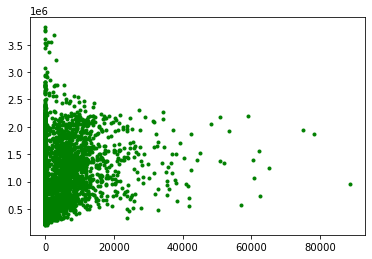

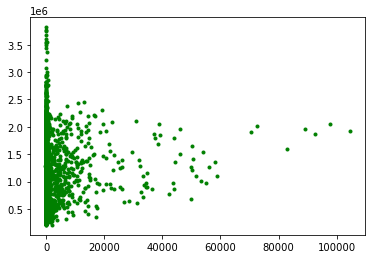

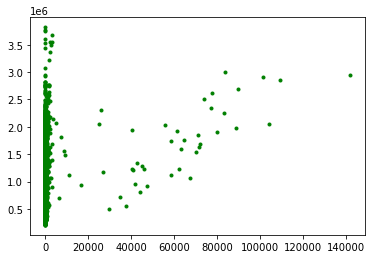

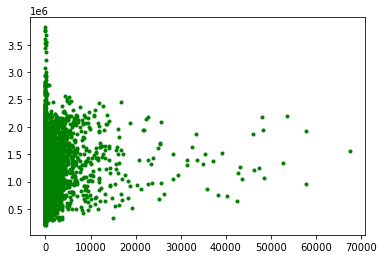

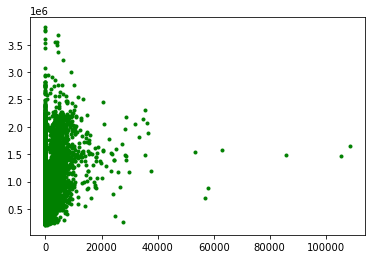

In [14]:
# Promotion 시리즈의 분포를 시각화

for i in range(1, 6):
    x = train_['Promotion{}'.format(str(i))]
    y = train_['Weekly_Sales']
    
    plt.plot(x, y, 'g.')
    plt.show()

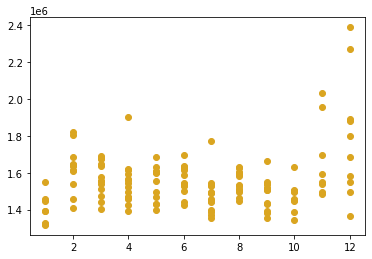

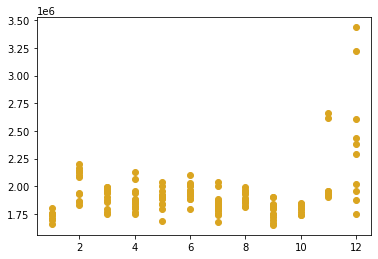

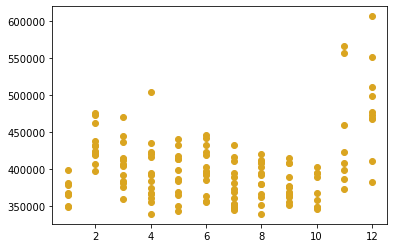

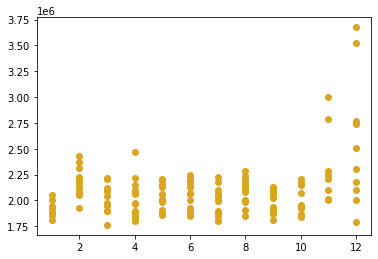

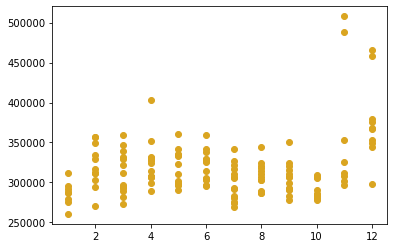

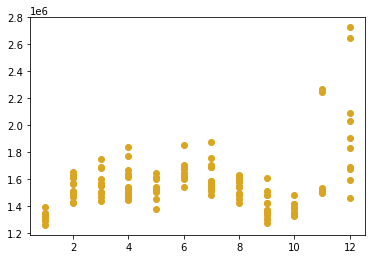

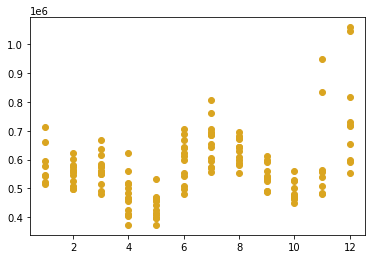

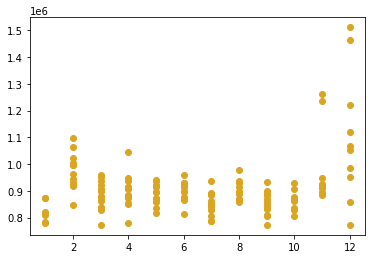

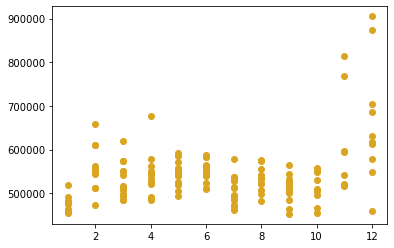

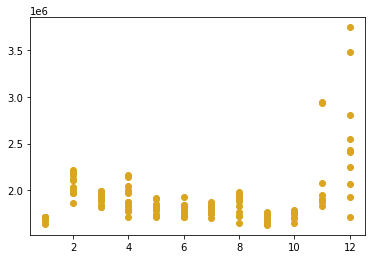

In [25]:
# 월별 매출액 시각화

for i in range(1, 11):
    tmp = train_[train_['Store'] == i]
    plt.plot(tmp['M'], tmp['Weekly_Sales'], 'o', color = 'goldenrod')
    plt.show()

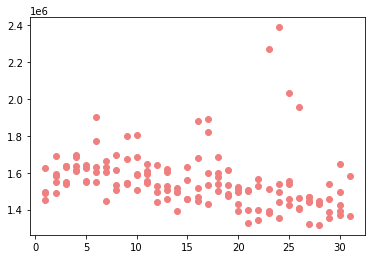

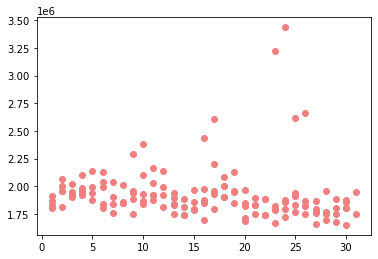

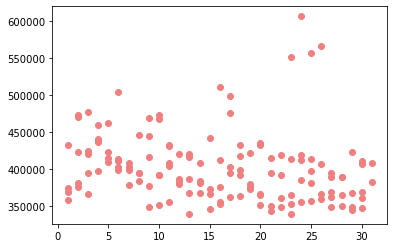

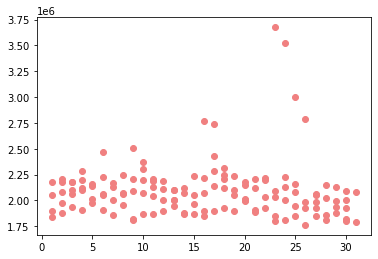

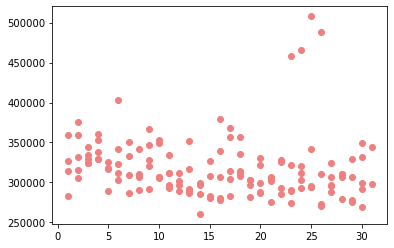

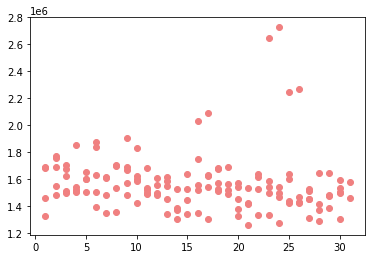

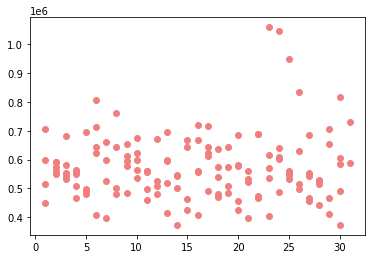

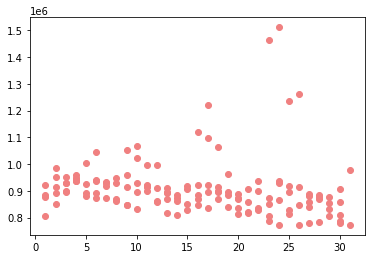

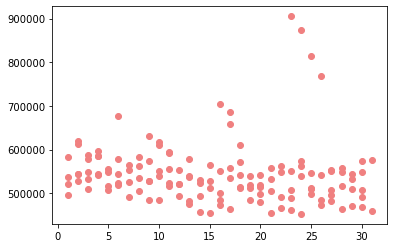

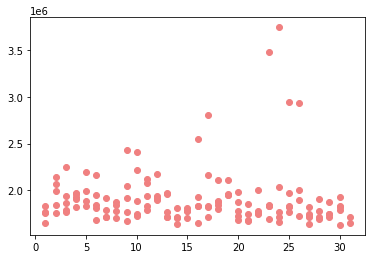

In [26]:
# 일별 매출액 시각화

for i in range(1, 11):
    tmp = train_[train_['Store'] == i]
    plt.plot(tmp['D'], tmp['Weekly_Sales'], 'o', color = 'lightcoral')
    plt.show()

In [15]:
# Numeric Value들을 Regression에 투입시켜보기

res = smf.ols(formula = 'Weekly_Sales ~ Y + M + D + Temperature + Fuel_Price + \
              Promotion1 + Promotion2 + Promotion3 + Promotion4 + Promotion5 + \
                Unemployment + Holiday', data = train_).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     63.95
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          2.67e-147
Time:                        13:30:30   Log-Likelihood:                -91362.
No. Observations:                6255   AIC:                         1.827e+05
Df Residuals:                    6242   BIC:                         1.828e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.645e+08   3.57e+07     15.821   

In [ ]:
# 추후 이상치 처리 등 전처리 작업이 필요할 것으로 보임